[View in Colaboratory](https://colab.research.google.com/github/divsinha99/Twitter-Sentiment-Analysis-using-PySpark/blob/master/C18007_BDSP_FinalProject_Twitter_sentiment_analysis.ipynb)

#  1.  Data Exploration:

## About the Data

The dataset for training the model is from "Sentiment140", a dataset originated from Stanford University. More info on the dataset can be found from the below link. http://help.sentiment140.com/for-students/

The dataset can be downloaded from the below link.
http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

## Format of the Data:

The description of the dataset from the link, the information on each field can be found.

The data is a CSV with emoticons removed. Data file format has 6 fields:
- 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- 1 - the id of the tweet (2087)
- 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- 3 - the query (lyx). If there is no query, then this value is NO_QUERY.
- 4 - the user that tweeted (robotickilldozr)
- 5 - the text of the tweet (Lyx is cool)

## Importing Libraries

In [9]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

First, columns names have been assigned to each column.

In [2]:
cols = ['sentiment','id','date','query_string','user','text']

## Uploading of file

In [3]:
from google.colab import files

uploaded = files.upload()

Saving trainingandtestdata.zip to trainingandtestdata.zip


In [5]:
import os

datasets_path = os.path.join('..', 'datalab')


In [14]:
!ls ../datalab

run.sh				training.1600000.processed.noemoticon.csv
testdata.manual.2009.06.14.csv	web


## Unzip file

In [13]:
import zipfile


with zipfile.ZipFile('trainingandtestdata.zip', "r") as z:
    z.extractall(datasets_path)

In [18]:
df = pd.read_csv("../datalab/training.1600000.processed.noemoticon.csv",header=None, names=cols, encoding='latin-1')
                              
                              
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment       1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
user            1600000 non-null object
text            1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [20]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

Dataset has 1.6million entries, with no null entries, and for the "sentiment" column, even though the dataset description mentioned neutral class, the training set has no neutral class. 50% of the data is with negative label, and another 50% with positive label. We can see there's no skewness on the class division.

In [21]:
df.query_string.value_counts()

NO_QUERY    1600000
Name: query_string, dtype: int64

Let's get started by dropping the columns that I don't need for the specific purpose of sentiment analysis.

- "id" column is unique ID for each tweet
- "date" column is for date info for the tweet
- "query_string" column indicates whether the tweet has been collected with any particular query keyword, but for this column, 100% of the entries are with value "NO_QUERY"
- "user" column is the twitter handle name for the user who tweeted


In [22]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [23]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [24]:
df[df.sentiment == 0].head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [25]:
df[df.sentiment == 4].head(10)

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
800005,4,@ProductOfFear You can tell him that I just bu...
800006,4,@r_keith_hill Thans for your response. Ihad al...
800007,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


It seems like that all the negative class is from 0~799999th index, and the positive class entries start from 800000 to the end of the dataset.

In [26]:
df[df.sentiment == 0].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            799990, 799991, 799992, 799993, 799994, 799995, 799996, 799997,
            799998, 799999],
           dtype='int64', length=800000)

In [27]:
df[df.sentiment == 4].index

Int64Index([ 800000,  800001,  800002,  800003,  800004,  800005,  800006,
             800007,  800008,  800009,
            ...
            1599990, 1599991, 1599992, 1599993, 1599994, 1599995, 1599996,
            1599997, 1599998, 1599999],
           dtype='int64', length=800000)

Mapped the class value of 4(positive) to 1.

In [28]:
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

In [29]:
df.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

# 2.  Data Preparation

In [30]:
df['pre_clean_len'] = [len(t) for t in df.text]

In [31]:
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}

pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 1:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


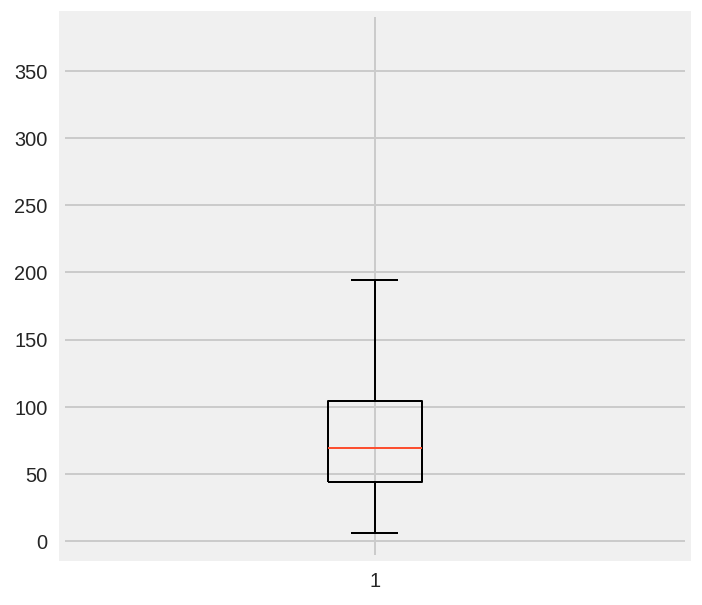

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [33]:
df[df.pre_clean_len > 140].head(10)

,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
226,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, ...",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quo...",150
747,0,Have an invite for &quot;Healthy Dining&quot; ...,141
957,0,Damnit I was really digging this season of Rea...,141
1064,0,Why do I keep looking...I know that what I rea...,141


## Data Preparation 1: HTML decoding

In [34]:
df.text[279]

"Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "

In [43]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], features='html.parser')
print(example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


## Data Preparation 2: @mention

In [44]:
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [45]:
import re
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

## Data Preparation 3: URL links

In [46]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [47]:
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

## Data Preparation 4: UTF-8 BOM (Byte Order Mark)

In [48]:
df.text[226]

'Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [56]:
testing = df.text[226].encode().decode("utf-8-sig")
testing

'Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [57]:
testing.replace("ï¿½", "?")

'Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

## Data Preparation 5: hashtag / numbers

In [58]:
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [59]:
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

## Defining data cleaning function

In [60]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [64]:
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, features='html.parser')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [65]:
testing = df.text[:100]

In [66]:
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

In [67]:
test_result

['awww that s a bummer you shoulda got david carr of third day to do it d',
 'is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 'k nope they didn t have it',
 'que me muera',
 'spring break in plain city it s snowing',
 'i just re pierced my ears',
 'i couldn t bear to watch it and i thought the ua loss was embarrassing',
 'it it counts idk why i did either you never talk to me anymore',
 'i would ve been the first but i didn t have a gun not really though zac snyder s just a doucheclown',
 'i wish i got to watch it with you i miss you and how was the premiere',
 'hollis death scene will hurt

In [68]:
nums = [0,400000,800000,1200000,1600000]

In [70]:
%%time
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 10000 of 400000 has been processed
Tweets 20000 of 400000 has been processed
Tweets 30000 of 400000 has been processed
Tweets 40000 of 400000 has been processed
Tweets 50000 of 400000 has been processed
Tweets 60000 of 400000 has been processed
Tweets 70000 of 400000 has been processed
Tweets 80000 of 400000 has been processed
Tweets 90000 of 400000 has been processed
Tweets 100000 of 400000 has been processed
Tweets 110000 of 400000 has been processed
Tweets 120000 of 400000 has been processed
Tweets 130000 of 400000 has been processed
Tweets 140000 of 400000 has been processed
Tweets 150000 of 400000 has been processed
Tweets 160000 of 400000 has been processed
Tweets 170000 of 400000 has been processed
Tweets 180000 of 400000 has been processed
Tweets 190000 of 400000 has been processed
Tweets 200000 of 400000 has been processed
Tweets 210000 of 400000 has been processed
Tweets 220000 of 400000 has been processed
Tweets 230000 of 400000 has

In [71]:
len(clean_tweet_texts)

400000

In [72]:
%%time
print("Cleaning and parsing the tweets...\n")
for i in range(nums[1],nums[2]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[2] ))
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 410000 of 800000 has been processed
Tweets 420000 of 800000 has been processed
Tweets 430000 of 800000 has been processed
Tweets 440000 of 800000 has been processed
Tweets 450000 of 800000 has been processed
Tweets 460000 of 800000 has been processed
Tweets 470000 of 800000 has been processed
Tweets 480000 of 800000 has been processed
Tweets 490000 of 800000 has been processed
Tweets 500000 of 800000 has been processed
Tweets 510000 of 800000 has been processed
Tweets 520000 of 800000 has been processed
Tweets 530000 of 800000 has been processed
Tweets 540000 of 800000 has been processed
Tweets 550000 of 800000 has been processed
Tweets 560000 of 800000 has been processed
Tweets 570000 of 800000 has been processed
Tweets 580000 of 800000 has been processed
Tweets 590000 of 800000 has been processed
Tweets 600000 of 800000 has been processed
Tweets 610000 of 800000 has been processed
Tweets 620000 of 800000 has been processed
Tweets 630000 of 8

In [73]:
len(clean_tweet_texts)

800000

In [74]:
%%time
print("Cleaning and parsing the tweets...\n")
for i in range(nums[2],nums[3]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[3] ))
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 810000 of 1200000 has been processed
Tweets 820000 of 1200000 has been processed
Tweets 830000 of 1200000 has been processed
Tweets 840000 of 1200000 has been processed
Tweets 850000 of 1200000 has been processed
Tweets 860000 of 1200000 has been processed
Tweets 870000 of 1200000 has been processed
Tweets 880000 of 1200000 has been processed
Tweets 890000 of 1200000 has been processed
Tweets 900000 of 1200000 has been processed
Tweets 910000 of 1200000 has been processed
Tweets 920000 of 1200000 has been processed
Tweets 930000 of 1200000 has been processed
Tweets 940000 of 1200000 has been processed
Tweets 950000 of 1200000 has been processed
Tweets 960000 of 1200000 has been processed
Tweets 970000 of 1200000 has been processed
Tweets 980000 of 1200000 has been processed
Tweets 990000 of 1200000 has been processed
Tweets 1000000 of 1200000 has been processed
Tweets 1010000 of 1200000 has been processed
Tweets 1020000 of 1200000 has been pro

In [75]:
len(clean_tweet_texts)

1200000

In [76]:
%%time
print("Cleaning and parsing the tweets...\n")
for i in range(nums[3],nums[4]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[4] ))                                        
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 1210000 of 1600000 has been processed
Tweets 1220000 of 1600000 has been processed
Tweets 1230000 of 1600000 has been processed
Tweets 1240000 of 1600000 has been processed
Tweets 1250000 of 1600000 has been processed
Tweets 1260000 of 1600000 has been processed
Tweets 1270000 of 1600000 has been processed
Tweets 1280000 of 1600000 has been processed
Tweets 1290000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1310000 of 1600000 has been processed
Tweets 1320000 of 1600000 has been processed
Tweets 1330000 of 1600000 has been processed
Tweets 1340000 of 1600000 has been processed
Tweets 1350000 of 1600000 has been processed
Tweets 1360000 of 1600000 has been processed
Tweets 1370000 of 1600000 has been processed
Tweets 1380000 of 1600000 has been processed
Tweets 1390000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1410000 of 1600000 has been processed
Tweets 1420000 of 1

In [77]:
len(clean_tweet_texts)

1600000

# Saving cleaned data as csv

In [78]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [82]:
clean_df.to_csv('clean_tweet.csv',encoding='utf-8', index=False)

In [86]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv, index_col=None)
my_df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [87]:
files.download('clean_tweet.csv')

#Uploading the Cleaned data

In [2]:
from google.colab import files

uploaded = files.upload()

Saving clean_tweet.zip to clean_tweet.zip


In [3]:
import os

datasets_path = os.path.join('..', 'datalab')

In [4]:
import zipfile


with zipfile.ZipFile('clean_tweet.zip', "r") as z:
    z.extractall(datasets_path)

In [5]:
!ls ../datalab

clean_tweet.csv  run.sh  web


#Initialize Spark

In [6]:
!apt-get update 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.2.1/spark-2.2.1-bin-hadoop2.7.tgz
!tar xf spark-2.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

sc = spark.sparkContext
sc

Hit:1 http://archive.ubuntu.com/ubuntu artful InRelease
Get:2 http://archive.ubuntu.com/ubuntu artful-updates InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful-backports InRelease [74.6 kB]
Get:4 http://security.ubuntu.com/ubuntu artful-security InRelease [83.2 kB]
Get:5 http://archive.ubuntu.com/ubuntu artful-updates/universe Sources [46.2 kB]
Get:6 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 Packages [365 kB]
Get:7 http://archive.ubuntu.com/ubuntu artful-updates/universe amd64 Packages [150 kB]
Get:8 http://security.ubuntu.com/ubuntu artful-security/universe Sources [21.5 kB]
Get:9 http://security.ubuntu.com/ubuntu artful-security/universe amd64 Packages [84.3 kB]
Fetched 914 kB in 1s (543 kB/s)
Reading package lists... Done


<SparkContext master=local[*] appName=pyspark-shell>

In [7]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import SQLContext

try:
    # create SparkContext on all CPUs available: in my case I have 4 CPUs on my laptop

    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


#Loading the Dataframe in Spark-SQL context.

In [8]:
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('../datalab/clean_tweet.csv')

In [9]:
type(df)

pyspark.sql.dataframe.DataFrame

In [10]:
df.show(5)

+--------------------+------+
|                text|target|
+--------------------+------+
|awww that s a bum...|     0|
|is upset that he ...|     0|
|i dived many time...|     0|
|my whole body fee...|     0|
|no it s not behav...|     0|
+--------------------+------+
only showing top 5 rows



In [11]:
df = df.dropna()

In [12]:
df.count()

1525679

In [13]:
(train_set, val_set, test_set) = df.randomSplit([0.98, 0.01, 0.01], seed = 2000)

# HashingTF + IDF + Logistic Regression

In [16]:

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

- Tokenization : Tokenizer() splits text into tokens. These tokens could be paragraphs, sentences or individual words. Here, we are tokenizing into words.
- Term Frequency TF: Term frequency - inverse term frequency is a feature vectorization method widely used in text mining to reflect the importance of a term to a document in the corpus (corpus is a large and structured set of texts)
 Denote a term by t, a document by d, and the corpus by D. Term frequency TF(t,d) is the number of times that term t appears in document d, while document frequency DF(t,D) is the number of documents that contains term t.
 If we only use term frequency to measure the importance, it is very easy to over-emphasize terms that appear very often but carry little information about the document, e.g., “a”, “the”, and “of”. If a term appears very often across the corpus, it means it doesn’t carry special information about a particular document. Inverse document frequency is a numerical measure of how much information a term provides:
There are several variants on the definition of term frequency and document frequency. In spark.mllib, we separate TF and IDF to make them flexible.  Our implementation of term frequency utilizes the hashing trick. A raw feature is mapped into an index (term) by applying a hash function. Then term frequencies are calculated based on the mapped indices. This approach avoids the need to compute a global term-to-index map, which can be expensive for a large corpus, but it suffers from potential hash collisions, where different raw features may become the same term after hashing. To reduce the chance of collision, we can increase the target feature dimension, i.e., the number of buckets of the hash table. The default feature dimension is 220=1,048,576.

In [18]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

+--------------------+------+--------------------+--------------------+--------------------+-----+
|                text|target|               words|                  tf|            features|label|
+--------------------+------+--------------------+--------------------+--------------------+-----+
|                   a|     0|                 [a]|(65536,[30802],[1...|(65536,[30802],[1...|  0.0|
|a actually don t ...|     0|[a, actually, don...|(65536,[1903,1588...|(65536,[1903,1588...|  0.0|
|a actually due to...|     0|[a, actually, due...|(65536,[338,1903,...|(65536,[338,1903,...|  0.0|
|a ah kan fb nih n...|     0|[a, ah, kan, fb, ...|(65536,[546,6387,...|(65536,[546,6387,...|  0.0|
|   a airfranceflight|     0|[a, airfranceflight]|(65536,[30802,527...|(65536,[30802,527...|  0.0|
+--------------------+------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [19]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.8608587198369572

In [21]:
evaluator.getMetricName()

'areaUnderROC'

In [22]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy

0.7912807621063773

# CountVectorizer + IDF + Logistic Regression

Count Vectorizer:

With count vectorizer, we merely count the appearance of the words in each text. For example, let’s say we have 3 documents in a corpus: “I love dogs”, “I hate dogs and knitting”, “Knitting is my hobby and my passion”. If we build vocabulary from these three sentences and represent each document as count vectors, it will look like below pictures.

![alt text](https://cdn-images-1.medium.com/max/800/1*LD5XaHzOnoniU4p137FL5g.jpeg)


But if the size of a corpus gets big, the number of vocabulary gets too big to process. With my 1.5 million tweets, if I build vocabulary without limiting the number of vocabulary, I will have more than 260,000 vocabularies. This means that the shape of training data will be around 1,500,000 x 260,000, this sounds too big to train various different models with. So I decided to limit the number of vocabularies, but I also wanted to see how the performance varies depending on the number of vocabularies.

vocabsize - Max size of the vocabulary. CountVectorizer will build a vocabulary that only considers the top vocabSize terms ordered by term frequency across the corpus.

In [23]:
%%time
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print ("Accuracy Score: {0:.4f}".format(accuracy))
print ("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.7979
ROC-AUC: 0.8675
CPU times: user 82 ms, sys: 18 ms, total: 100 ms
Wall time: 4min 48s


# N-gram Implementation

According to Wikipedia, “n-gram is a continuous sequence of n items from a given sequence of text or speech”. In other words, n-grams are simply all combinations of adjacent words or letters of length n that you can find in your source text. Below picture represents well how n-grams are constructed out of source text.

![alt text](https://cdn-images-1.medium.com/max/800/1*tufb2Ea4ZBVydTuvrIUT5A.png)

We will extract 5,460 features each from unigram, bigram, trigram in the first place, to have around 16,000 features in total in the end.

In [17]:
from pyspark.ml.feature import NGram, VectorAssembler

def build_ngrams_wocs(inputCol=["text","target"], n=3):
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=5460,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+lr)

In [19]:
%%time

from pyspark.ml.evaluation import BinaryClassificationEvaluator
trigramwocs_pipelineFit = build_ngrams_wocs().fit(train_set)
predictions_wocs = trigramwocs_pipelineFit.transform(val_set)
accuracy_wocs = predictions_wocs.filter(predictions_wocs.label == predictions_wocs.prediction).count() / float(val_set.count())

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

roc_auc_wocs = evaluator.evaluate(predictions_wocs)

# print accuracy, roc_auc
print ("Accuracy Score: {0:.4f}".format(accuracy_wocs))
print("ROC-AUC: {0:.4f}".format(roc_auc_wocs))

Accuracy Score: 0.8132
ROC-AUC: 0.8862
CPU times: user 202 ms, sys: 65 ms, total: 267 ms
Wall time: 13min 29s


This has given me the best result, accuracy has improved to 81%.

And finally on the final test set.

In [20]:
test_predictions = trigramwocs_pipelineFit.transform(test_set)
test_accuracy = test_predictions.filter(test_predictions.label == test_predictions.prediction).count() / float(test_set.count())
test_roc_auc = evaluator.evaluate(test_predictions)

# print accuracy, roc_auc
print ("Accuracy Score: {0:.4f}".format(test_accuracy))
print ("ROC-AUC: {0:.4f}".format(test_roc_auc))

Accuracy Score: 0.8167
ROC-AUC: 0.8886
